<br>

## Initial Setup

---


In [1]:
# Import the libraries
import typing
import langchain
from langchain.embeddings import *
from langchain.vectorstores import *
from langchain.chains import *
import langchain_openai
import langchain_groq
import langgraph
from langgraph.graph import *

<br>

## Step 1 - Define the State

---

Create a state object to hold the conversation history and any other relevant information:


In [2]:
class CustomerServiceState(typing.TypedDict):
    messages: typing.Annotated[list, langgraph.graph.message.add_messages]
    customer_info: dict
    issue_type: str
    reservation_details: dict
    policy_context: str

<br>

## Step 2 - Initialize the Graph

---

Create a StateGraph object to define the structure of your customer service system:

In [3]:
graph = langgraph.graph.StateGraph(CustomerServiceState)

<br>

## Step 3 - Define Nodes

---

Create nodes for different functions in your customer service system:

In [4]:
def greet_customer(state):
    # Logic to greet the customer
    return state

def identify_issue(state):
    # Logic to identify the customer's issue
    return state

def retrieve_policy(state):
    # Use RAG to retrieve relevant company policy
    policy_context = rag_policy_retrieval(state["issue_type"])
    state["policy_context"] = policy_context
    return state

def resolve_issue(state):
    # Logic to resolve the identified issue
    return state

def book_reservation(state):
    # Database operation to book a reservation
    reservation_details = db_book_reservation(state["reservation_details"])
    state["reservation_details"] = reservation_details
    return state

def cancel_reservation(state):
    # Database operation to cancel a reservation
    db_cancel_reservation(state["reservation_details"]["reservation_id"])
    state["reservation_details"] = {}
    return state

def update_reservation(state):
    # Database operation to update a reservation
    updated_details = db_update_reservation(state["reservation_details"])
    state["reservation_details"] = updated_details
    return state

def escalate_to_human(state):
    # Logic to escalate complex issues to a human agent
    return state

In [5]:
graph.add_node("greet", greet_customer)
graph.add_node("identify", identify_issue)
graph.add_node("retrieve_policy", retrieve_policy)
graph.add_node("resolve", resolve_issue)
graph.add_node("book", book_reservation)
graph.add_node("cancel", cancel_reservation)
graph.add_node("update", update_reservation)
graph.add_node("escalate", escalate_to_human)

<br>

## Step 4 - Define Edges and Flow

---

Connect the nodes to create the flow of your customer service system:

In [6]:
graph.add_edge(langgraph.graph.START, "greet")
graph.add_edge("greet", "identify")
graph.add_edge("identify", "retrieve_policy")

def route_issue(state):
    if state["issue_type"] == "booking":
        return "book"
    elif state["issue_type"] == "cancellation":
        return "cancel"
    elif state["issue_type"] == "update":
        return "update"
    elif state["issue_type"] == "complex":
        return "escalate"
    else:
        return "resolve"

graph.add_conditional_edges("retrieve_policy", route_issue)

graph.add_edge("book", "resolve")
graph.add_edge("cancel", "resolve")
graph.add_edge("update", "resolve")
graph.add_edge("resolve", langgraph.graph.END)
graph.add_edge("escalate", langgraph.graph.END)

<br>

## Step 5 - Implement LLM and RAG Integration

---

Use LangChain's ChatOpenAI for natural language processing and implement RAG for policy retrieval:

In [6]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA

In [7]:
# Groq LLM
llm = langchain_groq.ChatGroq(model="llama3-8b-8192")

# OpenAI LLM
llm = langchain_openai.ChatOpenAI()

In [8]:
# Embedding
embeddings = langchain.embeddings.OpenAIEmbeddings()

/home/predator/.cache/pypoetry/virtualenvs/enigma-code-0aWLlfTL-py3.9/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [13]:
!ls ./../datasets/rules_and_regulations.txt 

./../datasets/rules_and_regulations.txt


In [15]:
# Assume we have a vector store of company policies
vectorstore = FAISS.load_local("./../datasets/rules_and_regulations.txt", embeddings, allow_dangerous_deserialization=True)

RuntimeError: Error in faiss::FileIOReader::FileIOReader(const char*) at /project/faiss/faiss/impl/io.cpp:67: Error: 'f' failed: could not open ../datasets/rules_and_regulations.txt/index.faiss for reading: Not a directory

In [ ]:


def rag_policy_retrieval(issue_type):
    retriever = policy_vectorstore.as_retriever()
    qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever)
    result = qa_chain.run(f"What is the company policy regarding {issue_type}?")
    return result

def identify_issue_with_llm(state):
    response = llm.invoke(state["messages"][-1].content)
    # Process the response to update the state
    return state

graph.add_node("identify", identify_issue_with_llm)

<br>

## 6. Add Database Integration

---

Implement database operations for reservation management using SQLite:


In [16]:
import sqlite3

def db_book_reservation(details):
    conn = sqlite3.connect('reservations.db')
    cursor = conn.cursor()
    cursor.execute("""
        INSERT INTO reservations (customer_id, date, time)
        VALUES (?, ?, ?)
    """, (details['customer_id'], details['date'], details['time']))
    reservation_id = cursor.lastrowid
    conn.commit()
    conn.close()
    return {"reservation_id": reservation_id, **details}

def db_cancel_reservation(reservation_id):
    conn = sqlite3.connect('reservations.db')
    cursor = conn.cursor()
    cursor.execute("DELETE FROM reservations WHERE id = ?", (reservation_id,))
    conn.commit()
    conn.close()

def db_update_reservation(details):
    conn = sqlite3.connect('reservations.db')
    cursor = conn.cursor()
    cursor.execute("""
        UPDATE reservations
        SET date = ?, time = ?
        WHERE id = ?
    """, (details['date'], details['time'], details['reservation_id']))
    conn.commit()
    conn.close()
    return details

<br>

## 7. Add Error Handling and Persistence

---

Implement error handling and use LangGraph's built-in persistence:

In [17]:
def handle_error(error, state):
    # Logic to handle errors
    return state

graph.add_exception_handler(handle_error)

AttributeError: 'StateGraph' object has no attribute 'add_exception_handler'

<br>

## Step 8 - Compile and Run the Graph

---

Compile the graph and create a runnable object:

In [18]:
customer_service = graph.compile()

In [20]:
from IPython.display import *


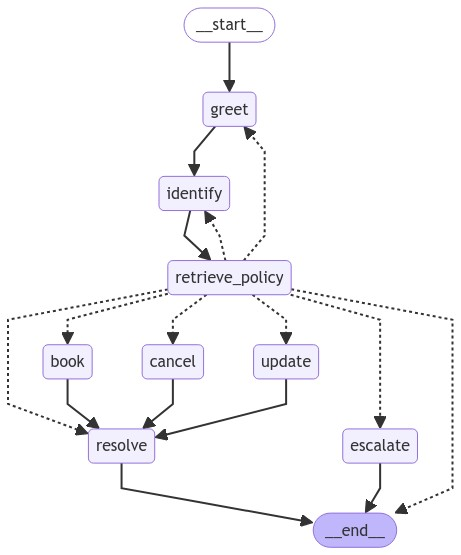

In [23]:
# Generate the image
image_data = customer_service.get_graph(xray=True).draw_mermaid_png()

# Save the image to a file
with open("graph.png", "wb") as f:
	f.write(image_data)

# Optionally, display the image in the notebook
display(Image(image_data, width=600, height=700))

Use the runnable object to process customer inquiries:

In [ ]:
final_state = customer_service.invoke({
    "messages": [{"role": "user", "content": "I need to book a reservation for tomorrow"}],
    "customer_info": {"id": 12345},
    "reservation_details": {"customer_id": 12345, "date": "2024-07-29", "time": "19:00"}
})

<br>

## Step 9 - Implement Monitoring and Feedback

---

Use Langfuse or other monitoring tools to track performance and gather user feedback:

In [ ]:
from langfuse.model import Trace

def process_customer_inquiry(inquiry):
    with Trace(name="customer_service_interaction") as trace:
        final_state = customer_service.invoke({"messages": [HumanMessage(content=inquiry)]})
        trace.score("customer_satisfaction", score=get_customer_feedback())
    return final_state

<br>

## 10 - Testing and Validation

---

Ensure thorough testing of each node and the overall workflow to validate the customer service system:

In [ ]:
def test_greet_customer():
    state = {"messages": [], "customer_info": {}, "issue_type": "", "reservation_details": {}, "policy_context": ""}
    updated_state = greet_customer(state)
    assert updated_state["messages"][-1]["content"] == "Welcome! How can I assist you today?"

test_greet_customer()